In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM, z_at_value
import astropy.units as u

### Setting up Cosmology

In [2]:
global cosmo
cosmo = FlatLambdaCDM(H0=67.8 * u.km / u.s / u.Mpc, Tcmb0=2.275 * u.K, Om0 = 0.308)

### Imports

In [3]:
folder = 'E:/GZ-DESI/data'

In [4]:
df_int = pd.read_parquet(f'{folder}/2023-03-15-cats/definitive-merged-interesting-params.parquet', engine = 'pyarrow')

In [5]:
df_noint = pd.read_parquet(
    f'{folder}/2023-03-15-cats/definitive-not-merged-interesting-params.parquet', 
    engine = 'pyarrow', 
    columns = ['id_str', 'category', 'redshift', 'elpetro_mass_log', 'log_m_bh','log_bolometric_l', 'total_sfr_avg']
)

In [6]:
list(df_int.columns)

['id_str',
 'merging_none_fraction',
 'merging_minor-disturbance_fraction',
 'merging_major-disturbance_fraction',
 'merging_merger_fraction',
 'category',
 'ra',
 'dec',
 'log_l_ha',
 'log_l_oiii',
 'photo_z',
 'spec_z',
 'redshift',
 'redshift_nsa',
 'total_sfr_avg',
 'elpetro_mass',
 'logMH',
 'elpetro_mass_log',
 'log_m_bh',
 'log_bolometric_l']

### Checking Redshift Distribution

In [7]:
df_z = df_int[['id_str', 'category', 'redshift']]

In [8]:
df_z_dna = df_z.dropna()

<AxesSubplot:ylabel='Frequency'>

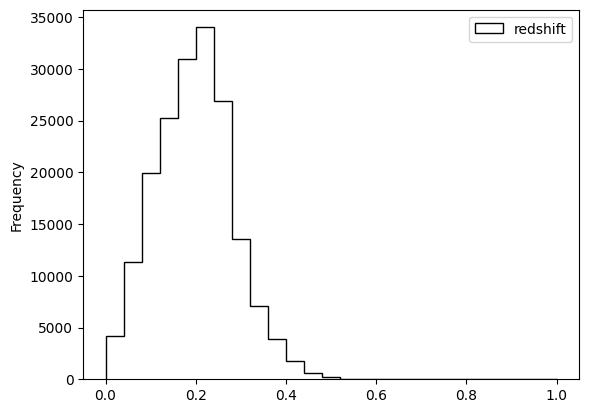

In [9]:
df_z_dna.plot.hist(
    by = 'redshift',
    bins = 25,
    xlabel = 'redshift',
    histtype = 'step',
    color='black'
)

### Defining Units of Co-Moving Distances

In [10]:
df_no_int_z = df_noint[['id_str','category', 'redshift']].dropna()
del df_noint

In [11]:
df_com = (
    df_z_dna
    .assign(com_dist = df_z_dna.redshift.apply(lambda x: cosmo.comoving_distance(x)))
)

In [12]:
df_noint_com = (
    df_no_int_z
    .assign(com_dist = df_no_int_z.redshift.progress_apply(lambda x: cosmo.comoving_distance(x)))
)

100%|██████████| 7189642/7189642 [04:52<00:00, 24572.17it/s]


In [13]:
mini = 0
# maxi = float(cosmo.comoving_distance(1) / u.Mpc)

In [108]:
bins_z = np.linspace(0.1,1,10)
bins = cosmo.comoving_distance(bins_z) / u.Mpc

In [109]:
def find_bin(d, bins):
    nbin = np.where(float(d / u.Mpc) <= bins)[0][0]
    nbin -= 1
    return nbin

In [110]:
df_com_bins = (
    df_com
    .assign(nbin = df_com.com_dist.progress_apply(lambda x: find_bin(x, bins)))
)

100%|██████████| 179604/179604 [00:06<00:00, 28613.53it/s]


In [111]:
df_noint_val = df_noint_com.query('redshift <= 1.0')
df_noint_com_bins = (
    df_noint_val
    .assign(nbin = df_noint_val.com_dist.progress_apply(lambda x: find_bin(x, bins)))
)

100%|██████████| 7189622/7189622 [05:26<00:00, 22031.41it/s]


In [112]:
fractions = []
for i in tqdm(range(len(bins))):
    n_int_gals = len(df_com_bins.query('nbin == @i'))
    n_non_int_gals = len(df_noint_com_bins.query('nbin == @i'))
    
    if n_non_int_gals == 0 or n_int_gals == 0:
        fractions.append(np.nan)
        continue
    
    fraction = n_int_gals / n_non_int_gals
    
    fractions.append(fraction)
    
frac_arr = np.asarray(fractions)

100%|██████████| 10/10 [00:01<00:00,  9.02it/s]


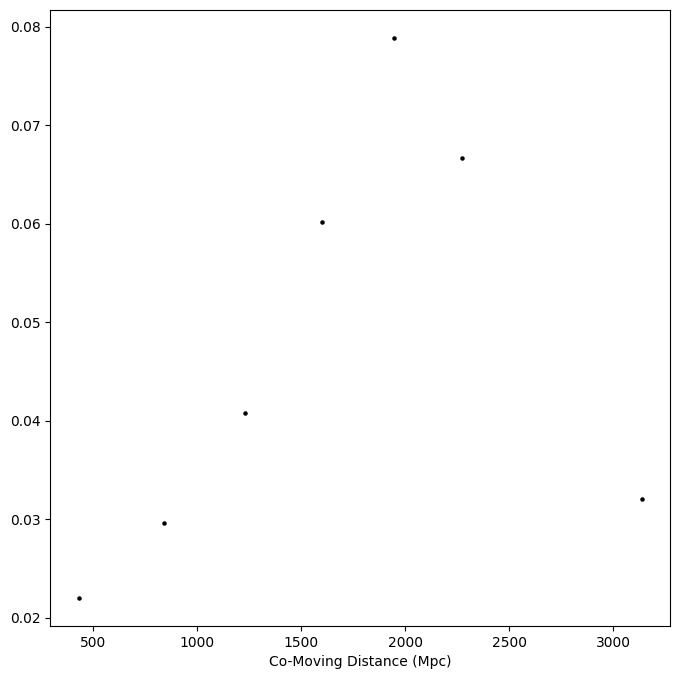

In [113]:
fig, ax1 = plt.subplots(figsize = (8,8))
ax1.scatter(bins, fractions, s=5, color='black')
ax1.set_xlabel('Co-Moving Distance (Mpc)')
plt.show()

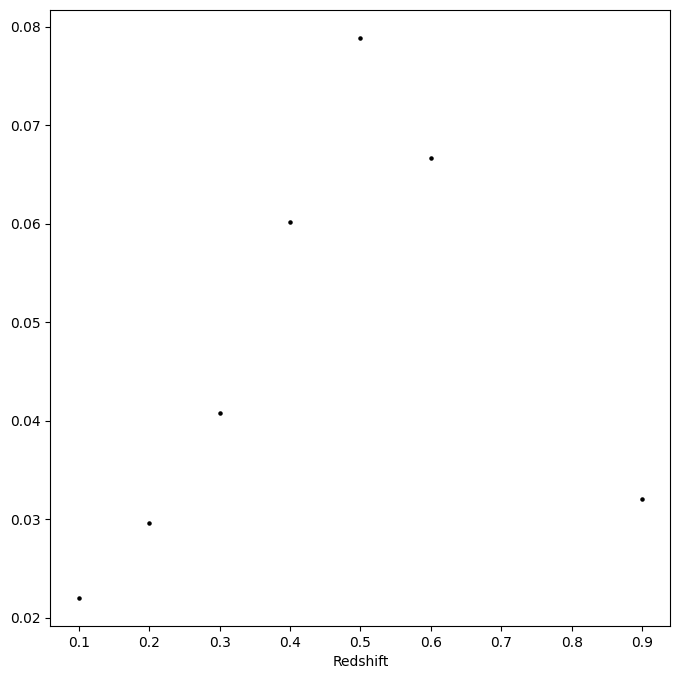

In [114]:
fig, ax1 = plt.subplots(figsize = (8,8))
ax1.scatter(bins_z, fractions, s=5, color='black')
ax1.set_xlabel('Redshift')
plt.show()

In [115]:
redshift_bin = bins_z[1] - bins_z[0]
redshift_bin

0.1

In [116]:
d_bin = bins[1] - bins[0]
d_bin * u.Mpc

<Quantity 410.44994035 Mpc>

## Calculating Merger Rates

So, to calculate the merger rate we need to follow the methodology of Lotz et al. 2011. The equation for merger rate is:

    Lambda_merg = number density of merger candidates / average T from encounter to coalescence.
    
Or, we can calculate the fractional merger rate, given by:

    R_merg = C_merg * f_pair / average coalescence time.
    
So, what do we get?

They find that for stellar masses >= 10^{10} solar masses, average coalescence time = 0.21 Gyrs.

### Assuming all are above Stellar Mass 10$^{10}$

In [117]:
comb_df = pd.DataFrame(data = zip(bins, bins_z,fractions)).rename(columns = {0 : 'comoving-dist', 1 : 'redshift',2 : 'fraction'})

In [118]:
comb_df.head()

,comoving-dist,redshift,fraction
0,431.7729410021839,0.1,0.022014
1,842.2228813494168,0.2,0.029588
2,1230.9940556448782,0.3,0.040724
3,1598.2337740651199,0.4,0.060146
4,1944.4846766929575,0.5,0.078876


In [119]:
def calc_rate(frac):
    if frac == np.nan:
        return np.nan
    else:
        return frac / 0.21

In [120]:
rate_df = (
    comb_df
    .assign(merg_rate = comb_df.fraction.apply(lambda x: calc_rate(x)))
)

In [121]:
lotz_major = 0.03 * (1 + bins_z)**1.7
lotz_minor = 0.27 * (1 + bins_z)**-0.1

Text(0.5, 1.0, 'Merger Rate')

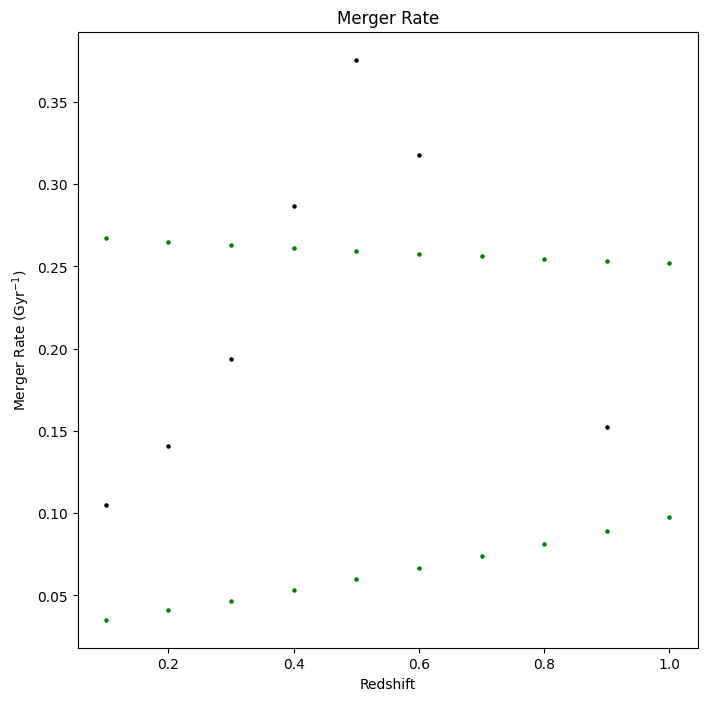

In [122]:
fig, ax = plt.subplots(nrows = 1, figsize = (8,8))
rate_df.plot.scatter(
    x = 'redshift',
    y = 'merg_rate',
    s=5,
    color='black',
    ax = ax
)
ax.scatter(bins_z, lotz_minor, color = 'green', s = 5, label = 'Lotz Minor')
ax.scatter(bins_z, lotz_major, color = 'green', s = 5, label = 'Lotz Major')
ax.set_xlabel('Redshift')
ax.set_ylabel('Merger Rate (Gyr$^{-1}$)')
ax.set_title('Merger Rate')

### Checking Number Density

In [123]:
def find_bin_z(z, bins):
    nbin = np.where(float(z) <= bins)[0][0]
    nbin -= 1
    return nbin

In [124]:
df_z_dna_bin = (
    df_z_dna
    .assign(bins = df_z_dna.redshift.apply(lambda x: find_bin_z(x, bins_z)))
)

In [125]:
n = []
for i in range(50):
    n.append(len(df_z_dna_bin.query('bins == @i')))

In [126]:
df_n = pd.DataFrame(data = zip(bins_z, n)).rename(columns = {0 : 'red_bin', 1 : 'ngals'})

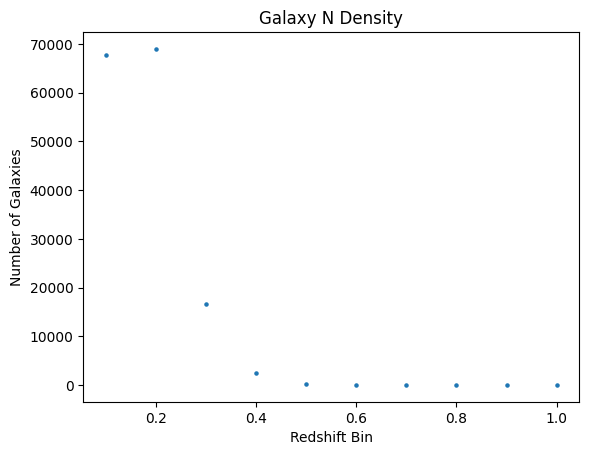

In [127]:
fig, ax1 = plt.subplots(nrows = 1)
df_n.plot.scatter(
    x = 'red_bin',
    y = 'ngals',
    s = 5,
    ax = ax1
)
ax1.set_xlabel('Redshift Bin')
ax1.set_ylabel('Number of Galaxies')
ax1.set_title('Galaxy N Density')
plt.show()

In [128]:
comoving_volume = cosmo.comoving_volume(bins_z)

In [129]:
comoving_volume

<Quantity [3.37174619e+08, 2.50247483e+09, 7.81369539e+09, 1.71005281e+10,
           3.07965583e+10, 4.90338525e+10, 7.17288596e+10, 9.86540556e+10,
           1.29493970e+11, 1.63886751e+11] Mpc3>

In [130]:
gal_density = list(df_n.ngals) / comoving_volume

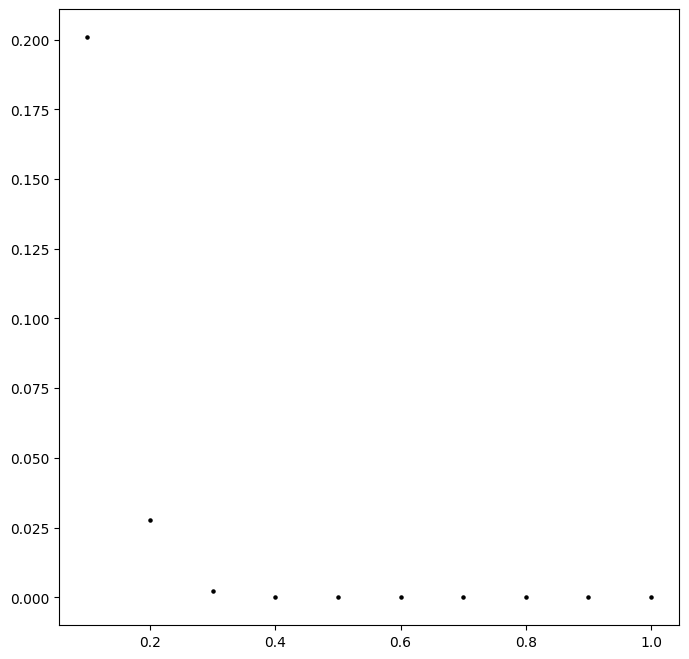

In [131]:
plt.figure(figsize = (8,8))
plt.scatter(bins_z, gal_density / 1e-3, color = 'black', s =5)
plt.show()